<a href="https://colab.research.google.com/github/kristinkx/KristinKX/blob/main/V7_Philadelphia_Crime_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIS5450 FALL 2022 Philadelphia Crime Dataset**

**TEAM 28**

---

---
- Member: **QI Zhao; KRISTIN Xie**
- Mentor: **Rushab Manthripragada**


# Part 0: Packages and Datasets

The dataset we are using is from `https://www.opendataphily.org/`, which has been uploaded to a public S3 bucket for simple accessibility.

In our project we mainly use 3 datasets:
- `crime.csv`: There are over 3 million records with information like crime type and time reported.
- `address_with_num_of_hospitals`: number of hospitals within 1 km in each zipcode.
- `address_with_num_of_schools`: number of schools within 1 km in each zipcode.


In [ ]:
!pip3 install opendatasets pandas wordcloud geopy geopandas pandasql imbalanced-learn

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 671, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 843, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/cmdoptions.py", line 23, in <module>
    from pip._internal.cli.parser import ConfigOptionParser
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/parser.py", line 12, in <module>
    from pip._internal.configuration import Configuration, ConfigurationError
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/configuration.py", line 21, in <module>
    from pip._internal.exceptions import (
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/exceptions.py", line 8, in <module>
    from pip._vendor.requests.models import Request, Response
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/requests/__init__.py", line 43, in <module>


In [ ]:
import pandasql as ps
import math 
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 7)  # adjusts the configuration of the plots we will create
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
 

# model
import imblearn
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, f1_score, accuracy_score, classification_report, roc_curve, auc, precision_recall_curve 
from sklearn.ensemble import RandomForestClassifier   
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier  
import numpy as np
from datetime import datetime 
import wordcloud 
from geopy.distance import geodesic as GD
import opendatasets as od
import pandas as pd
# Download data 
for file in ['address_with_num_of_hospitals', 'address_with_num_of_schools','crime']:
  od.download(f"https://demo-sparc-bucket2.s3.amazonaws.com/{file}.csv")
 

Using downloaded and verified file: ./address_with_num_of_hospitals.csv
Using downloaded and verified file: ./address_with_num_of_schools.csv
Using downloaded and verified file: ./crime.csv


# Part 1: ETL & EDA

In this section we will clean the data and do some exploratory data analysis.

## 1.1 Data Reading and Description

In [ ]:
# read the philadelphia crime data
philadelphia = pd.read_csv('crime.csv')
address_hospitals = pd.read_csv('address_with_num_of_hospitals.csv')
address_schools = pd.read_csv('address_with_num_of_schools.csv')
philadelphia.head()

Dc_Dist Psa   Dispatch_Date_Time Dispatch_Date Dispatch_Time  Hour  \
0       18   3  2009-10-02 14:24:00    2009-10-02      14:24:00    14   
1       14   1  2009-05-10 00:55:00    2009-05-10      00:55:00     0   
2       25   J  2009-08-07 15:40:00    2009-08-07      15:40:00    15   
3       35   D  2009-07-19 01:09:00    2009-07-19      01:09:00     1   
4        9   R  2009-06-25 00:14:00    2009-06-25      00:14:00     0   

         Dc_Key            Location_Block  UCR_General   Text_General_Code  \
0  200918067518  S 38TH ST  / MARKETUT ST        800.0      Other Assaults   
1  200914033994          8500 BLOCK MITCH       2600.0  All Other Offenses   
2  200925083199               6TH CAMBRIA        800.0      Other Assaults   
3  200935061008       5500 BLOCK N 5TH ST       1500.0   Weapon Violations   
4  200909030511       1800 BLOCK WYLIE ST       2600.0  All Other Offenses   

   Police_Districts    Month        Lon        Lat  
0               NaN  2009-10        NaN        NaN  
1               NaN  2009-05        NaN        NaN  
2               NaN  2009-08        NaN        NaN  
3              20.0  2009-07 -75.130477  40.036389  
4               8.0  2009-06 -75.166350  39.969532

In [ ]:
# print data info
print(f'data has {philadelphia.shape[0]} rows and {philadelphia.shape[1]} columns\n')
print("""data info\n
===================""")
print(philadelphia.info())
print("""basic statistics:/n
===================""")
print(philadelphia.describe())

data has 2237605 rows and 14 columns

data info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237605 entries, 0 to 2237604
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Dc_Dist             int64  
 1   Psa                 object 
 2   Dispatch_Date_Time  object 
 3   Dispatch_Date       object 
 4   Dispatch_Time       object 
 5   Hour                int64  
 6   Dc_Key              int64  
 7   Location_Block      object 
 8   UCR_General         float64
 9   Text_General_Code   object 
 10  Police_Districts    float64
 11  Month               object 
 12  Lon                 float64
 13  Lat                 float64
dtypes: float64(4), int64(3), object(7)
memory usage: 239.0+ MB
None
basic statistics:/n
            Dc_Dist          Hour        Dc_Key   UCR_General  \
count  2.237605e+06  2.237605e+06  2.237605e+06  2.236942e+06   
mean   1.726837e+01  1.315990e+01  2.010975e+11  1.271354e+03   
std    1.064898e+01  6.799

## 1.2 Missing data

There aren't many missing data for Lat and Lon (which are the important columns we will use). So we can simply remove the missing data.

In [ ]:
# find null data

print(philadelphia.isnull().sum())

philadelphia = philadelphia[philadelphia['Lat'].isna() == False]

Dc_Dist                   0
Psa                       0
Dispatch_Date_Time        0
Dispatch_Date             0
Dispatch_Time             0
Hour                      0
Dc_Key                    0
Location_Block            0
UCR_General             663
Text_General_Code       663
Police_Districts      19930
Month                     0
Lon                   17349
Lat                   17349
dtype: int64


## 1.3 Column Selection and Value Replacing

- We only need part of the columns so we will drop some columns. 
- For the crime type we will update the way they were named. 
- For the Lat and Lon we need the precision to be 3.
- Merge the main dataset with 2 other datasets to get number of schools and hospitals within 1 km.
- Date parsing: parse date into year, month, date and weekday

In [ ]:
# make a copy of the original philadelphia file and drop some columns
# and clean the data from the copy

philadelphia = philadelphia[['Dispatch_Date', 'Hour', 'Text_General_Code', 'Psa',
                       'Location_Block', 'Police_Districts', 'Lon', 'Lat' ]]

# Replace Text_General_Code

philadelphia['Text_General_Code'] = philadelphia['Text_General_Code'].replace({'Homicide - Criminal': 'Homicide_Criminal', 
                                     'Aggravated Assault Firearm': 'Aggravated_Assault_Firearm', 
                                     'Robbery Firearm': 'Robbery_Firearm', 'Theft from Vehicle': 'Theft_from_Vehicle',           
                                     'Homicide - Gross Negligence' : 'Homicide_Gross_Negligence',
                                     'All Other Offenses' : 'All_Other_Offenses',
                                     'Homicide - Justifiable': 'Homicide_Justifiable',
                                     'Weapon Violations' : "Weapon_Violations", 
                                     'Other Assaults': 'Other_Assaults',
                                     'Burglary Residential': 'Burglary_Residential',
                                     'Aggravated Assault No Firearm': 'Aggravated_Assault_No_Firearm',
                                     'Robbery No Firearm': 'Robbery_No_Firearm',
                                     'Motor Vehicle Theft':'Motor_Vehicle_Theft',
                                     'Disorderly Conduct':'Disorderly_Conduct',
                                     'Burglary Non-Residential': 'Burglary_Non_Residential',
                                     'Liquor Law Violations': 'Liquor_Law_Violations', 
                                     'Forgery and Counterfeiting': 'Forgery_and_Counterfeiting',
                                     'Public Drunkenness':'Public_Drunkenness',
                                     'Offenses Against Family and Children': 'Offenses_Against_Family_and_Children',
                                     'Gambling Violations': 'Gambling_Violations',
                                     'Receiving Stolen Property': 'Receiving_Stolen_Property',
                                     'Other Sex Offenses (Not Commercialized)': 'Other_Sex_Offenses_(Not_Commercialized)',
                                     'Narcotic / Drug Law Violations': 'Narcotic_Drug_Law_Violations',
                                     'DRIVING UNDER THE INFLUENCE':'DRIVING_UNDER_THE_INFLUENCE',
                                     'Vagrancy/Loitering': 'Vagrancy_Loitering',
                                     'Prostitution and Commercialized Vice':'Prostitution_and_Commercialized_Vice',
                                     'Vandalism/Criminal Mischief':'Vandalism_Criminal_Mischief',
                                     'Recovered Stolen Motor Vehicle':'Recovered_Stolen_Motor_Vehicle',
                                     })

# Round Lat and Lon
philadelphia['Lon'] = philadelphia['Lon'].apply(lambda x: round(x,3))
philadelphia['Lat'] = philadelphia['Lat'].apply(lambda x: round(x,3))

# Merge data
philadelphia = philadelphia.merge(address_schools[['Lat','Lon','num_of_schools']],on=['Lat','Lon'], how='inner')\
                           .merge(address_hospitals[['Lat','Lon','num_of_hospitals']], on=['Lat','Lon'], how='inner')
philadelphia = philadelphia.reset_index()

print(f'new data has {philadelphia.shape[0]} rows and {philadelphia.shape[1]} columns\n')

# 1.1.6 split dispatch_date_time to year, month, day and weekday

philadelphia['year'] = pd.DatetimeIndex(philadelphia['Dispatch_Date']).year
philadelphia['month'] = pd.DatetimeIndex(philadelphia['Dispatch_Date']).month
philadelphia['day'] = pd.DatetimeIndex(philadelphia['Dispatch_Date']).day
philadelphia['weekday'] = pd.DatetimeIndex(philadelphia['Dispatch_Date']).day_of_week
philadelphia.head(3)

new data has 2220256 rows and 11 columns



index Dispatch_Date  Hour             Text_General_Code Psa  \
0      0    2009-07-19     1             Weapon_Violations   D   
1      1    2009-10-07     1  Narcotic_Drug_Law_Violations   B   
2      2    2009-01-05    12                         Fraud   B   

             Location_Block  Police_Districts    Lon     Lat  num_of_schools  \
0       5500 BLOCK N 5TH ST              20.0 -75.13  40.036               5   
1  5600 BLOCK N LAWRENCE ST              20.0 -75.13  40.036               5   
2     400 BLOCK W OLNEY AVE              20.0 -75.13  40.036               5   

   num_of_hospitals  year  month  day  weekday  
0                68  2009      7   19        6  
1                68  2009     10    7        2  
2                68  2009      1    5        0

# Part 2: Crime Data Visualization

Let's do some simple visualization to understand the data.

## 2.1 Records count

Let's count the number of crimes based on different categories:
- crime category
- years, month, weekday, hour
- police district

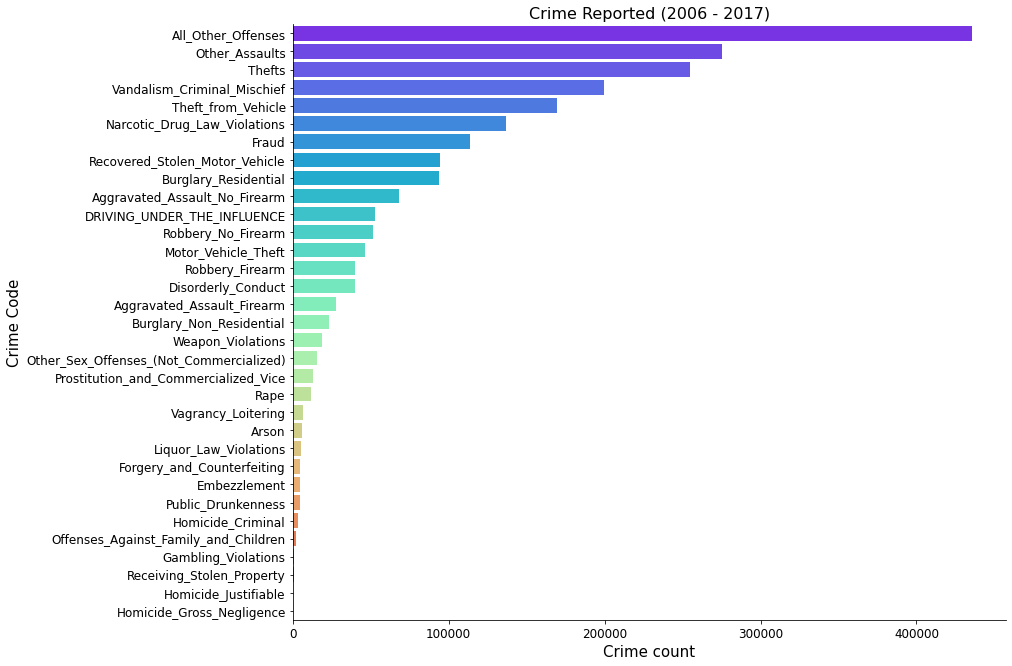

In [ ]:
# plot graph for crime category

sns.catplot(y='Text_General_Code',
           kind ='count',
           height = 9,
           aspect = 1.5, 
           palette=("rainbow"),
           order=philadelphia.Text_General_Code.value_counts().index,
           data=philadelphia)

plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Crime count", fontsize = 15)
plt.ylabel("Crime Code", fontsize = 15)
plt.title("Crime Reported (2006 - 2017)", fontsize = 16);

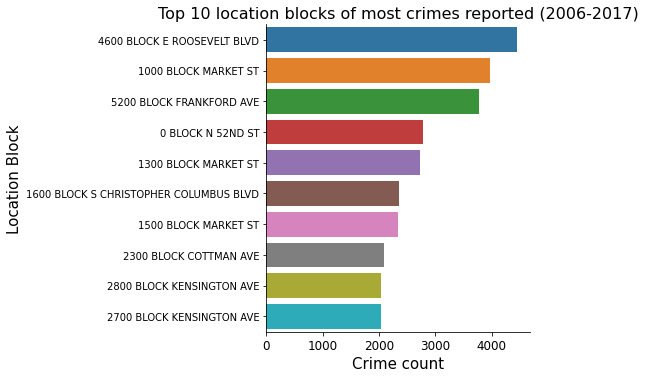

In [ ]:
## top 10 blocks with most crime reported

sns.catplot(y='Location_Block',
           kind ='count',
           height = 5,
           aspect = 1.5, 
           palette=("tab10"),
           order=philadelphia.Location_Block.value_counts().nlargest(10).index,
           data=philadelphia)

plt.xticks(size=12)
plt.yticks(size=10)
plt.xlabel("Crime count", fontsize = 15)
plt.ylabel("Location Block", fontsize = 15)
plt.title("Top 10 location blocks of most crimes reported (2006-2017)", fontsize = 16);

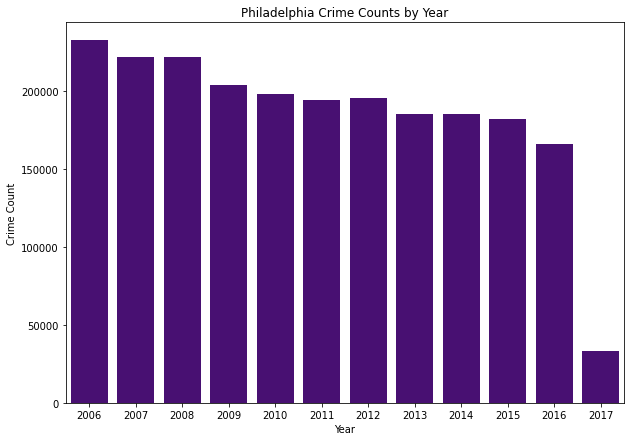

In [ ]:
# plot graph of crimes over the years (2006 - 2017)

year_list = philadelphia.year.tolist()

dist_bins = np.array(year_list)
sns.countplot(philadelphia['year'], color='indigo')
plt.title("Philadelphia Crime Counts by Year")
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.show()

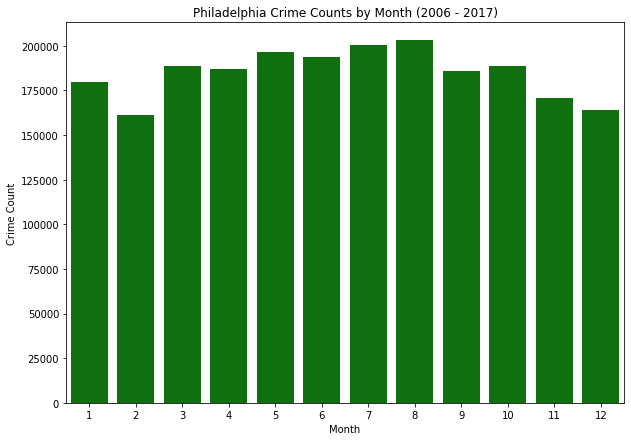

In [ ]:
# plot graph of the crime by month

philadelphia_month = philadelphia.month.tolist()

dist_bins = np.array(philadelphia_month)
sns.countplot(philadelphia['month'], color='green')
plt.title("Philadelphia Crime Counts by Month (2006 - 2017)")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.show()

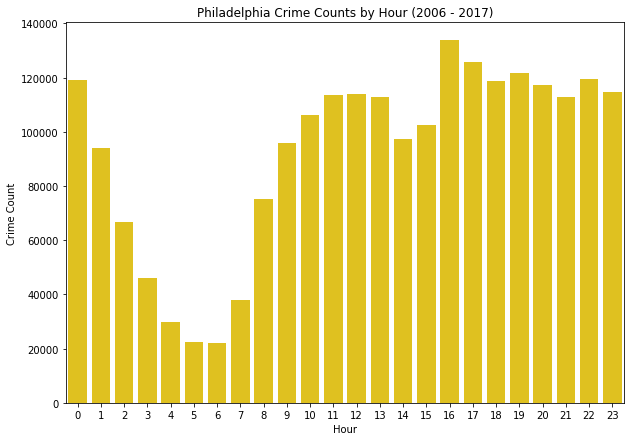

In [ ]:
# plot graph of the crime by hour

philadelphia_hour = philadelphia.Hour.tolist()

dist_bins = np.array(philadelphia_hour)
sns.countplot(philadelphia['Hour'], color='gold')
plt.title("Philadelphia Crime Counts by Hour (2006 - 2017)")
plt.xlabel("Hour")
plt.ylabel("Crime Count")
plt.show()

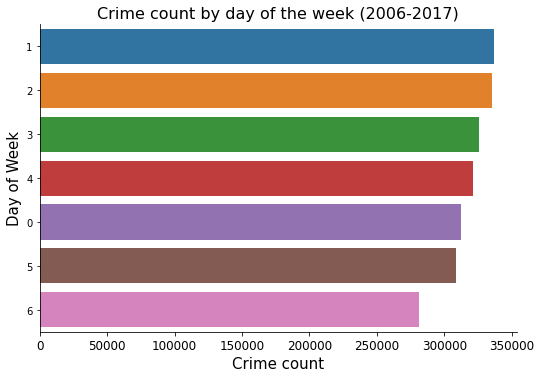

In [ ]:
## crime count by day of the week

sns.catplot(y='weekday',
           kind ='count',
           height = 5,
           aspect = 1.5, 
           palette=("tab10"),
           order=philadelphia.weekday.value_counts().index,
           data=philadelphia)

plt.xticks(size=12)
plt.yticks(size=10)
plt.xlabel("Crime count", fontsize = 15)
plt.ylabel("Day of Week", fontsize = 15)
plt.title("Crime count by day of the week (2006-2017)", fontsize = 16);

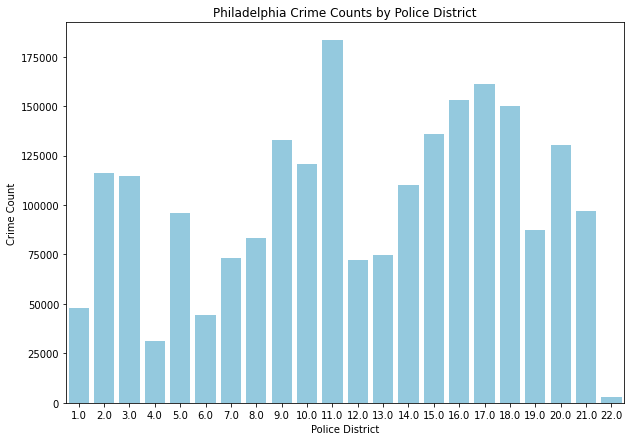

In [ ]:
# plot graph of crime by police district

police = philadelphia.Police_Districts.tolist()

dist_bins = np.array(police)
sns.countplot(philadelphia['Police_Districts'], color='skyblue')
plt.title("Philadelphia Crime Counts by Police District")
plt.xlabel("Police District")
plt.ylabel("Crime Count")
plt.show()

## 2.2 Word Cloud 

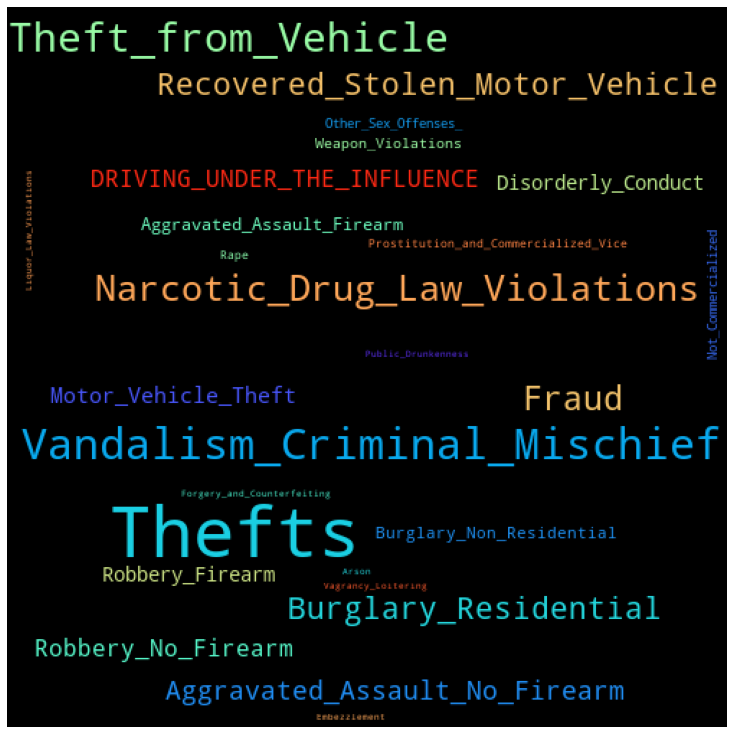

In [ ]:
# wordcloud crimes report in the dataset
from wordcloud import WordCloud
 
philadelphia_cloud = philadelphia.copy()
philadelphia_cloud = philadelphia_cloud.dropna(subset=['Text_General_Code'])
cloud = philadelphia_cloud[philadelphia_cloud['Text_General_Code']!='All_Other_Offenses']
cloud = cloud[cloud['Text_General_Code']!='Other_Assaults']
most_common = " ".join(i for i in cloud['Text_General_Code'])
wordcloud = WordCloud(width = 500, height = 500, 
                      background_color = 'black',
                      mask = None,  contour_color = 'blue',  
                      min_font_size = 6, collocations=False,
                      max_font_size = None, mode = 'RGB',
                      colormap = 'rainbow').generate(most_common) 
# plot word cloud
plt.figure(figsize = (15, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## 2.3 Geographic Distribution

From the data we can see that there are some main crime types. They are:
- Theft_from_Vehicle
- Thefts
- Homicide_Criminal
- Homicide_Gross_Negligence
- Homicide_Justifiable
- Robbery_Firearm
- Aggravated_Assault_Firearm
- Weapon_Violations

Now let's take a look at these common cases in 2016 and plot them on a map.

In [ ]:
import folium
from folium.plugins import HeatMap
from folium import plugins
# philly crime heatmap (use the most recent 200000 crimes reported in the philly dataset)

lon = philadelphia['Lon']
lat = philadelphia['Lat']

average_Lon = sum(lon)/len(lon)
average_Lat = sum(lat)/len(lat)

dc_location = philadelphia[['Police_Districts', 'Lon', 'Lat']]
dc = dc_location.groupby(['Police_Districts']).mean().reset_index()

# this part calls the folium.Map funcion, the bigger the zoom_start, the closer in 
crime_map = folium.Map(location=[average_Lat, average_Lon],
                      zoom_start = 11)

# add the crime data to the heat map
crime_heatmap = philadelphia[-200000:]
crime_heatmap = crime_heatmap[['Lat','Lon']]
data_heatmap = [[row['Lat'],row['Lon']] for index, row in crime_heatmap.iterrows()]
HeatMap(crime_heatmap, radius = 12).add_to(crime_map)

folium.TileLayer('openstreetmap').add_to(crime_map)
# folium.TileLayer('stamenterrain').add_to(crime_map) # works

# folium.TileLayer('Mapbox Bright').add_to(crime_map) # does not work


crime_map

In [ ]:
# map of 500 major crimes reported in August 2016 (August was month with highest
# crime reported and 2016 was the most recent year in the philadelphia dataset.
# NOTE: 2017 dataset has a few months not the whole year)
# we will create a subset based on philadelphia and include homicide, robbery and theft

major_crime_query = '''
SELECT *
FROM philadelphia
WHERE "Text_General_Code" == "Theft_from_Vehicle" 
OR "Text_General_Code" == "Thefts"
OR "Text_General_Code" == "Homicide_Criminal"
OR "Text_General_Code" == "Homicide_Gross_Negligence"
OR "Text_General_Code" == "Homicide_Justifiable"
OR "Text_General_Code" == "Robbery_Firearm"
OR "Text_General_Code" == "Aggravated_Assault_Firearm"
OR "Text_General_Code" == "Weapon_Violations"
ORDER BY year DESC
'''

major_crime = ps.sqldf(major_crime_query, globals()) 

# if we plot a graph for all the major crimes (count > 500k) in a map
# it will crash the session (yeah I tried....)

# therefore we can plot the 500 major crimes committed in August 

major_2016_query = '''
SELECT *
FROM major_crime
WHERE year = 2016
AND month = 8
ORDER BY day DESC
LIMIT 500
'''

major_2016 = ps.sqldf (major_2016_query, globals())

In the map we will use the color to denote the severity of a crime type:

- Black: Homicide
- Blue: Theft type of crimes
- Red: Weapon crimes
- Green: Firearm

In [ ]:
# visualization of the selected major_crimes

# add colors column for the major crime 

def select_marker_color(row):
    if row['Text_General_Code'] == 'Aggravated_Assault_Firearm':
        return 'green'
    elif row['Text_General_Code'] == 'Homicide_Criminal':
        return 'black'
    elif row['Text_General_Code'] == 'Homicide_Justifiable':
        return 'black'
    elif row['Text_General_Code'] == 'Homicide_Gross_Negligence':
        return 'black'
    elif row['Text_General_Code'] == 'Weapon_Violations':
        return 'red'
    elif row['Text_General_Code'] == 'Theft_from_Vehicle':
        return 'blue'
    elif row['Text_General_Code'] == 'Thefts':
        return 'blue'
    else: 
        return 'gold'

major_crime['colors'] = major_crime.apply(select_marker_color, axis = 1 )
major_crime['Text_General_Code'].unique()

array(['Theft_from_Vehicle', 'Thefts', 'Weapon_Violations',
       'Robbery_Firearm', 'Aggravated_Assault_Firearm',
       'Homicide_Criminal', 'Homicide_Gross_Negligence',
       'Homicide_Justifiable'], dtype=object)

In [ ]:
# major crimes in August, 2016 in philadelphia map
# interactive: the 'i' on the markers shows the police district where the crime committed

major_2016_map = folium.Map(
    location = [40.033,-75.091], zoom_start = 2
)

for _, scene in major_2016.iterrows():
    folium.Marker(
    location = [scene['Lat'], scene['Lon']],
        popup = scene['Police_Districts'], 
        icon = folium.Icon(color = scene['colors'])
    ).add_to(major_2016_map)
    
major_2016_map

# Part 3: Machine Learning Modelling

Now let's define the problem and run some machine learning models.

The **question** we are interested in is, given an area, should we avoid parking in this area? In other words, we want to predict the car theft rate in an area using all other information except the car theft data. In order to do this we will need to do some preprocessing and feature engineer. We will use both regression and classification techniques to try to answer the question.

- Regression: Predict an area's car theft cases
- Classification: Wether an area has car theft accidents (>0) or not (=0).

## 3.1 Data Preprocessing

- `Pivot table`: We will create a pivot table to have count of each crime type happened in each area
- `Feature engineering`: We will merge the data to get the number of schools and hospitals within 1 km of a geolocation 
- `Target fields`: We need to create 2 target fields:
  - `num_of_car_theft`: number of car theft in the area
  - `has_car_theft`: whether a car theft happened in this area before

In [ ]:
data = philadelphia.copy()
data['count'] = 1
data = data[['Lat','Lon','Text_General_Code','count']].groupby(['Lat','Lon','Text_General_Code']).count()
data = data.reset_index().pivot_table('count', ['Lat', 'Lon'], 'Text_General_Code').fillna(0).reset_index()

data['num_of_car_theft']= data['Motor_Vehicle_Theft'] + data['Theft_from_Vehicle']
data['has_car_theft'] = (data['num_of_car_theft']>0).astype(int)
# Drop the 2 columns
data = data.drop(columns = ['Motor_Vehicle_Theft','Theft_from_Vehicle'])


print('Count for whether there is a car theft', data['has_car_theft'].value_counts())


Count for whether there is a car theft 1    21317
0     2876
Name: has_car_theft, dtype: int64


## 3.2 Train Test Split



In [ ]:
# train test data split
# build a linear regression model: given all other crimes, predict the num_of_car_theft

X = data[['Weapon_Violations',
                      'All_Other_Offenses',
                                  'Thefts',
                          'Other_Assaults',
                      'Disorderly_Conduct',
                                   'Arson',
                                   'Fraud',            
                      'Robbery_No_Firearm',
                         'Robbery_Firearm',                  
                                    'Rape',
                    'Burglary_Residential',
                      'Vagrancy_Loitering',
                            'Embezzlement',
                       'Homicide_Criminal',
            'Narcotic_Drug_Law_Violations',
             'Vandalism_Criminal_Mischief',
                     'Gambling_Violations',
           'Aggravated_Assault_No_Firearm',
              'Aggravated_Assault_Firearm',
 'Other_Sex_Offenses_(Not_Commercialized)',
    'Prostitution_and_Commercialized_Vice',
              'Forgery_and_Counterfeiting',
                'Burglary_Non_Residential',
             'DRIVING_UNDER_THE_INFLUENCE',
                      'Public_Drunkenness',
                   'Liquor_Law_Violations',
               'Receiving_Stolen_Property',
          'Recovered_Stolen_Motor_Vehicle',
               'Homicide_Gross_Negligence',
    'Offenses_Against_Family_and_Children',
                    'Homicide_Justifiable']]

y = data[['num_of_car_theft']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 0, test_size = 0.2)

# **Part 3. Machine Learning Modelling**



## 3.3: Regression models

### 3.3.1: Linear regression Model 

We will use Linear model to predict the number of the motor/vehicle theft in an area.

In [ ]:

clf = LinearRegression()
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print('The mean squared error is', mean_squared_error(y_test, y_predict))

The mean squared error is 74.72837607283618


### 3.3.2 Optimization

The data is sparse so we may use some regularization technique.

However it doesn't seem to do much to the result.

In [ ]:

clf = Lasso(alpha=0.1)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print('The mean squared error is', mean_squared_error(y_test, y_predict))

The mean squared error is 74.90571248389583


## 3.4 Classification Models

We will need to modify the target value in the classification.

In [ ]:
y = data[['has_car_theft']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 0, test_size = 0.2)

### 3.4.1 Logistic Regression Model 

Predict if there is motor/vehicle theft in a given geo location (lat/lon) based on all other crimes in the dataset*

In [ ]:
# one-verse-rest logistic model (if the given geo area is likely to have motor/vehicle theft)
# use all other crime types (except Motor theft and vehicle theft) to predict the num_of_car_theft category
# the predict score ~ 88%

log_model = LogisticRegression(multi_class='ovr')
log_model = log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

print('The accuracy rate is', accuracy_score(y_test, y_pred))
print('The F1 score is', f1_score(y_test, y_pred))
print('The confusion matrix is\n', confusion_matrix(y_test, y_pred))

The accuracy rate is 0.8735275883446993
The F1 score is 0.931065555305249
The confusion matrix is
 [[  94  493]
 [ 119 4133]]


### 3.4.2 K-Nearesr Neighbour (KNN)

In [ ]:
# define the model: intialize KNN
classifier = KNeighborsClassifier(n_neighbors = 69, p = 22, metric = 'euclidean')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print('The accuracy rate is', accuracy_score(y_test, y_pred))
print('The F1 score is', f1_score(y_test, y_pred))
print('The confusion matrix is\n', confusion_matrix(y_test, y_pred))

The accuracy rate is 0.8871667699938004
The F1 score is 0.9365263892118112
The confusion matrix is
 [[ 265  322]
 [ 224 4028]]


### 3.4.3 Optimization

The data is highly imbalanced so the accuracy rate isn't meaningful. We may use some sampoverling technique to improve this issue.

After this we apply logistic regression again.

In [ ]:

oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)


In [ ]:

log_model = LogisticRegression(multi_class='ovr')
log_model = log_model.fit(X_over, y_over)
y_pred = log_model.predict(X_test)

print('The accuracy rate is', accuracy_score(y_test, y_pred))
print('The F1 score is', f1_score(y_test, y_pred))
print('The confusion matrix is\n', confusion_matrix(y_test, y_pred))

The accuracy rate is 0.7728869601157264
The F1 score is 0.8538369464024471
The confusion matrix is
 [[ 530   57]
 [1042 3210]]


# PART 4: Conclusion

We have learned a lot through this project.

Since car/motor theft is not a common case, the final dataset we created are highly imbalanced. Therefore, the accuracy itself is not a good indicator of how appropriate a model is. In this case, F1 score would be a better indicator. With oversampling technique and logistic regression we achieved the best result. (0.85 F1 score)